In [1]:
# import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd

We want to create a function to read in the files, Westeros_gen_model.csv and Westeros_gen_model.csv, and create a dataframe with the data. We will also create a function to plot the data.

In [2]:
# function to read in the data
def read_data(filename):
    # read in the data with c   olumn headings in the first row
    df = pd.read_csv(filename, header=0)
    # reset the column headings as year, month, day, and generation
    df.columns = ['Year', 'Month', 'Day', 'Generation']
    # convert the Year, Month and Day columns to a datetime object
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']], format='%Y-%m-%d',errors='coerce')
    # drop the Year, Month and Day columns
    df = df.drop(['Year', 'Month', 'Day'], axis=1)
    # set the Date column as the index
    df = df.set_index('Date')
    # return the dataframe
    return df

# import the data
westeros_gen_obs = read_data('Westeros_gen_obs.csv')
westeros_gen_model = read_data('Westeros_gen_model.csv')

In [3]:
#westeros_gen_obs

In [4]:
#westeros_gen_model

In [5]:
# we now want to regress the uncalibrated model data against the observed data using all days of the observed dataset to obtain linear regression parameters (intercept and slope)

# define a function to perform this regression
def regression(obs, model):
    # create a dataframe to store the regression parameters
    df = pd.DataFrame(columns=['Intercept', 'Slope'])
    # loop through the columns in the obs dataframe
    for col in obs.columns:
        # perform the regression
        slope, intercept = np.polyfit(model[col], obs[col], 1)
        # add the regression parameters to the dataframe
        df.loc[col] = [intercept, slope]
    # return the dataframe
    return df

# perform the regression for only the period where the datetimes overlap from 2018-01-01 to 2019-12-31
westeros_gen_obs = westeros_gen_obs.loc['2018-01-01':'2019-12-31']
westeros_gen_model = westeros_gen_model.loc['2018-01-01':'2019-12-31']
# perform the regression
westeros_gen_reg = regression(westeros_gen_obs, westeros_gen_model)

# show the df containing the regression parameters
# westeros_gen_reg

In [6]:
# we now want to apply the regression parameters to the uncalibrated model data to obtain the calibrated model data

# define a function to perform this calibration
def calibration(model, reg):
    # create a dataframe to store the calibrated model data
    df = pd.DataFrame(columns=model.columns)
    # loop through the columns in the model dataframe
    for col in model.columns:
        # apply the regression parameters to the model data
        df[col] = model[col] * reg.loc[col, 'Slope'] + reg.loc[col, 'Intercept']
    # return the dataframe containing the calibrated model data
    return df

# perform the calibration
westeros_gen_cal = calibration(westeros_gen_model, westeros_gen_reg)

# show the df containing the calibrated model data
westeros_gen_cal

,Generation
Date,
2018-01-01,788.127878
2018-01-02,780.026208
2018-01-03,387.135114
2018-01-04,301.859653
2018-01-05,418.370855
...,...
2019-12-27,336.481615
2019-12-28,313.746834
2019-12-29,398.348275


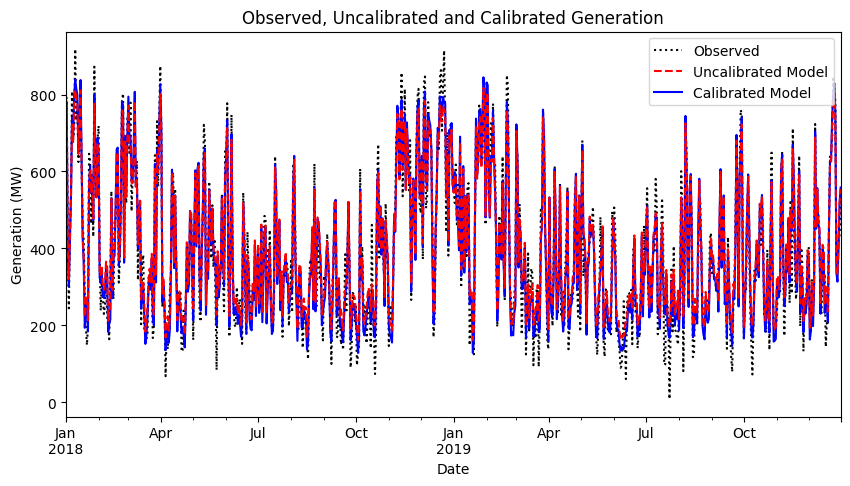

In [12]:
# we now want to plot the observed data, uncalibrated model data and calibrated model data

# define a function to plot the data
def plot_data(obs, model, cal):
    # create a figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    # plot the observed data
    obs.plot(ax=ax, color='k', label='Observed',linestyle=':')
    # plot the calibrated model data
    cal.plot(ax=ax, color='b', label='Calibrated Model')
    # plot the uncalibrated model data
    model.plot(ax=ax, color='r', label='Uncalibrated Model',linestyle='--')
    # set the x-axis label
    ax.set_xlabel('Date')
    # set the y-axis label
    ax.set_ylabel('Generation (MW)')
    # set the title
    ax.set_title('Observed, Uncalibrated and Calibrated Generation')
    # set the legend
    # specify the labels in the legend as Observed, Uncalibrated Model and Calibrated Model
    l = ['Observed', 'Uncalibrated Model', 'Calibrated Model']
    # specify the colours in the legend as black, red and blue
    h = [plt.Line2D((0, 1), (0, 0), color='k',linestyle=':'), plt.Line2D((0, 1), (0, 0), color='r',linestyle='--'), plt.Line2D((0, 1), (0, 0), color='b')]
    # create a legend
    ax.legend(h, l)
    # show the plot
    plt.show()

# plot the data
plot_data(westeros_gen_obs, westeros_gen_model, westeros_gen_cal)

In [8]:
# define a function to perform an ordinary least squares regreesion to calculate the correlation between the observed and calibrated model data

import scipy
from scipy import stats

def correlation(obs, model):
    # create a dataframe to store the correlation
    df = pd.DataFrame(columns=['Correlation'])
    # loop through the columns in the obs dataframe
    for col in obs.columns:
        # perform the regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(obs[col], model[col])
        # add the correlation to the dataframe
        df.loc[col] = r_value
    # return the dataframe
    return df

# perform the correlation for the uncalibrated model data
westeros_gen_cor = correlation(westeros_gen_obs, westeros_gen_model)
# perform the correlation for the calibrated model data
westeros_gen_cor_cal = correlation(westeros_gen_obs, westeros_gen_cal)

In [23]:
westeros_gen_cor.loc['Generation', 'Correlation']

0.9627949250157127

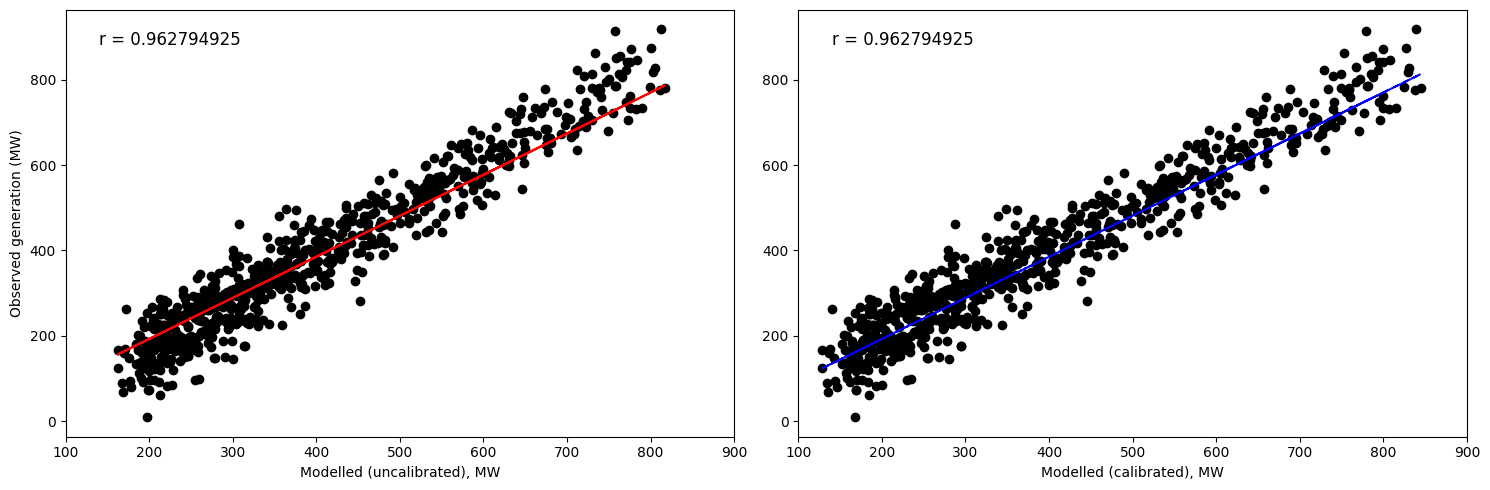

In [25]:
# now plot two subplots, the one on the left shows the obsered data (as scatter points) and the linear regression line for the uncalibrated model data, the one on the right shows the observed data (as scatter points) and the linear regression line for the calibrated model data

# set up the figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# plot the observed data as scatter points
ax1.scatter(westeros_gen_model, westeros_gen_obs, color='k', label='Uncalibrated Model')
# plot the linear regression line for the uncalibrated model data
ax1.plot(westeros_gen_model, westeros_gen_model * westeros_gen_cor.loc['Generation','Correlation'], color='r', label='Linear Regression')
# plot the calibrated model data
#ax1.plot(westeros_gen_cal,westeros_gen_cal * westeros_gen_cor_cal.loc['Generation', 'Correlation'], color='b', label='Calibrated Model',linestyle='--')

# display the r value on the plot
ax1.text(0.05, 0.95, 'r = ' + str(round(westeros_gen_cor.loc['Generation', 'Correlation'], 10)), transform=ax1.transAxes, fontsize=12, verticalalignment='top')

# set xlimits between 100 and 1000
ax1.set_xlim(100, 900)

# plot the observed data as scatter points
ax2.scatter(westeros_gen_cal, westeros_gen_obs, color='k', label='Calibrated Model')

# plot the linear regression line for the calibrated model data
ax2.plot(westeros_gen_cal, westeros_gen_cal * westeros_gen_cor_cal.loc['Generation', 'Correlation'], color='b', label='Linear Regression',linestyle='--')

# display the r value on the plot
ax2.text(0.05, 0.95, 'r = ' + str(round(westeros_gen_cor_cal.loc['Generation', 'Correlation'], 10)), transform=ax2.transAxes, fontsize=12, verticalalignment='top')

# set xlim
ax2.set_xlim(100, 900)

# set the x-axis label
ax1.set_xlabel('Modelled (uncalibrated), MW')
ax2.set_xlabel('Modelled (calibrated), MW')
# set the y-axis label
ax1.set_ylabel('Observed generation (MW)')

# specify a tight layout
plt.tight_layout()

# show the figure
plt.show()




Both the uncalibrated and calibrated are pretty good datasets. The uncalibrated model data is a little bit too high, but the calibrated model data is a good fit to the observed data. The calibrated model data is a better fit to the observed data, so we will use this for the rest of the analysis. The r value for the calibrated model data is very slightly higher than the r value for the uncalibrated model data, so the calibrated model data is a better fit to the observed data.

In [11]:
# sense checking the calibrated model data
# combine the observed data, uncalibrated model data and calibrated model data into a single dataframe
westeros_gen = pd.concat([westeros_gen_obs, westeros_gen_model, westeros_gen_cal], axis=1)

# rename the columns
westeros_gen.columns = ['Observed', 'Uncalibrated Model', 'Calibrated Model']

# show the dataframe
westeros_gen.head()

,Observed,Uncalibrated Model,Calibrated Model
Date,,,
2018-01-01,807.752755,765.301074,788.127878
2018-01-02,786.536312,757.893850,780.026208
2018-01-03,422.115978,398.679945,387.135114
2018-01-04,244.356222,320.713985,301.859653
2018-01-05,432.528485,427.238272,418.370855


In [64]:
# now create a function to apply the regression paramaters to the entir 30-year uncalibrated model data, the result of this will be the deterministic model dataset

# define the function
def apply_regression_params(df, params):
    # create a dataframe to store the calibrated model data
    df_cal = pd.DataFrame(columns=df.columns)
    # loop through the columns in the dataframe
    for col in df.columns:
        # apply the regression parameters to the data intercept + slope * data
        df_cal[col] = params.loc[col, 'Intercept'] + params.loc[col, 'Slope'] * df[col]
    # return the calibrated model data
    return df_cal

# import the data again to get the full time extent
westeros_gen_model = read_data('Westeros_gen_model.csv')

# apply the regression parameters to the uncalibrated model data
westeros_gen_deter_model_dataset = apply_regression_params(westeros_gen_model, westeros_gen_reg)

# show the dataframe
westeros_gen_deter_model_dataset

,Generation
Date,
1980-01-01,531.818217
1980-01-02,384.724698
1980-01-03,617.492948
1980-01-04,456.095327
1980-01-05,245.929885
...,...
2019-12-27,336.481615
2019-12-28,313.746834
2019-12-29,398.348275


In [61]:
westeros_gen_model.head()

,Generation
Date,
1980-01-01,530.961341
1980-01-02,396.476141
1980-01-03,609.292347
1980-01-04,461.729141
1980-01-05,269.578312


In [62]:
westeros_gen_deter_model_dataset.head()

,Generation
Date,
1980-01-01,531.818217
1980-01-02,384.724698
1980-01-03,617.492948
1980-01-04,456.095327
1980-01-05,245.929885


In [63]:
westeros_gen_obs.head()

,Date,Generation
0,2018-01-01,807.752755
1,2018-01-02,786.536312
2,2018-01-03,422.115978
3,2018-01-04,244.356222
4,2018-01-05,432.528485


In [74]:
## calculate the annual mean generation for the observed data, the uncalibrated model data and the calibrated model data. The years are from 1980 to 2019 and are in datetime format in the 'Date' column of the dataframes

# import the datasets
westeros_gen_obs = read_data('Westeros_gen_obs.csv')
westeros_gen_model = read_data('Westeros_gen_model.csv')

# calculate the annual mean generation for the observed data
# first convert the date column to a datetime object
westeros_gen_obs['Date'] = pd.to_datetime(westeros_gen_obs['Date'])

# extract the year from each date
westeros_gen_obs['Year'] = westeros_gen_obs['Date'].dt.year

# group the data by year and calculate the mean
westeros_gen_obs_annual = westeros_gen_obs.groupby('Year').mean()

# keep only the mean of the generation column
westeros_gen_obs_annual = westeros_gen_obs_annual['Generation']


# give up on this now, it's not working!!

# test for github

KeyError: 'Date'